In [3]:
# Imports
import pandas as pd

# Load the data
df = pd.read_csv(r"C:\Users\soura\Downloads\archive (15)\uber_reviews_without_reviewid.csv")

# Convert date
df['at'] = pd.to_datetime(df['at'], errors='coerce')

# Filter to last 6 months (e.g., from October 2023)
df = df[df['at'] >= '2023-10-01']

# Drop any rows with missing review content or score
df = df.dropna(subset=['content', 'score'])

# Preview cleaned data
print(df[['at', 'score', 'content']].head())




                   at  score          content
0 2024-12-18 17:17:19      5             Good
1 2024-12-18 17:17:17      5             Nice
2 2024-12-18 17:09:42      5  Very convenient
3 2024-12-18 17:08:27      4             Good
4 2024-12-18 17:08:16      5         exllence
                      at  score  \
6771 2024-12-04 13:22:17      5   
6469 2024-12-05 00:13:45      5   
1460 2024-12-15 12:53:08      5   
4039 2024-12-10 00:43:47      5   
99   2024-12-18 12:34:40      5   

                                                content  
6771                                           Exlenent  
6469                                           Nice app  
1460                                               Good  
4039                                                Wow  
99    I love that the fairs are so cheap and the dri...  


C:\Users\soura\AppData\Local\Temp\ipykernel_6424\3303752445.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\soura\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\soura\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


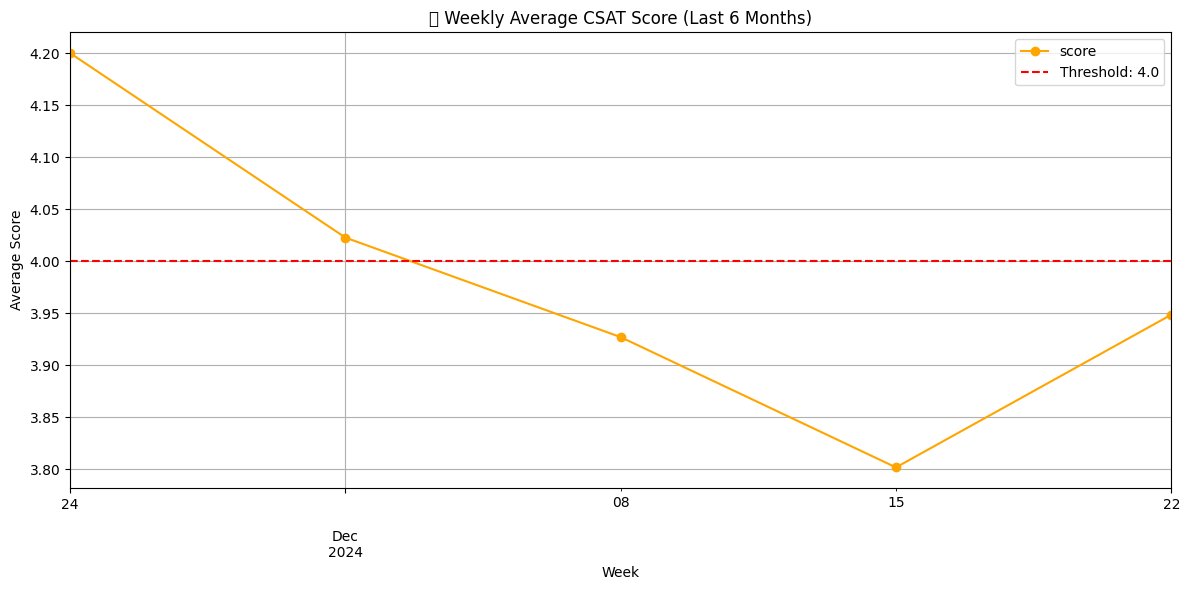

In [4]:
import matplotlib.pyplot as plt

# Resample by week to get average rating
weekly_csat = df.set_index('at').resample('W')['score'].mean()

# Plot
plt.figure(figsize=(12,6))
weekly_csat.plot(marker='o', color='orange')
plt.title("Weekly Average CSAT Score (Last 6 Months)")
plt.xlabel("Week")
plt.ylabel("Average Score")
plt.axhline(y=4.0, color='red', linestyle='--', label='Threshold: 4.0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
# Focused window for review analysis
drop_reviews = df[(df['at'] >= '2024-12-01') & (df['at'] <= '2024-12-20')]
print(drop_reviews[['at', 'score', 'content']].sample(5))  # Sanity check


                      at  score  \
5607 2024-12-06 19:53:52      5   
7543 2024-12-03 01:25:55      5   
2538 2024-12-13 09:45:27      2   
6936 2024-12-04 05:05:34      1   
6906 2024-12-04 06:48:17      5   

                                                content  
5607                                       Good service  
7543  I've ride with Uber several times and have nev...  
2538  Ever since I updated the app, it has been pick...  
6936  Disgusting service. My trip is usually a 5 to ...  
6906                               I love Uber...❤️❤️❤️  


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Drop to lowercase, remove nulls
texts = drop_reviews['content'].dropna().str.lower()

# Vectorize
vectorizer = CountVectorizer(stop_words='english', max_features=30)
X = vectorizer.fit_transform(texts)

# Sum word counts
word_freq = np.array(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()

# Create DataFrame of top keywords
top_keywords = pd.DataFrame({'word': words, 'frequency': word_freq})
top_keywords = top_keywords.sort_values(by='frequency', ascending=False)

print(top_keywords.head(10))


          word  frequency
13        good       2381
27        uber       1692
0          app       1443
8       driver       1100
23     service       1098
21        ride       1052
18        nice        781
25        time        742
9      drivers        710
12  experience        538


In [6]:
# Define complaint keywords by theme
complaint_keywords = {
    'late_pickup': ['late', 'delay', 'wait', 'waiting'],
    'app_issues': ['crash', 'bug', 'not working', 'slow', 'error'],
    'driver_behavior': ['rude', 'bad behavior', 'impolite', 'unprofessional'],
    'cancellations': ['cancel', 'cancelled', 'cancellation'],
    'pricing': ['expensive', 'price', 'overcharged', 'fare'],
}

# Function to label complaints
def label_complaint(text):
    text = text.lower()
    labels = []
    for category, keywords in complaint_keywords.items():
        if any(keyword in text for keyword in keywords):
            labels.append(category)
    return labels if labels else ['no_issue']

# Apply to review content
drop_reviews['complaint_tags'] = drop_reviews['content'].dropna().apply(label_complaint)

# Explode to count frequencies
exploded = drop_reviews.explode('complaint_tags')
complaint_counts = exploded['complaint_tags'].value_counts()

print(complaint_counts)


complaint_tags
no_issue           7520
pricing             530
cancellations       458
late_pickup         433
app_issues           81
driver_behavior      55
Name: count, dtype: int64


C:\Users\soura\AppData\Local\Temp\ipykernel_5852\547855201.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_reviews['complaint_tags'] = drop_reviews['content'].dropna().apply(label_complaint)


In [7]:
from scipy.stats import ttest_ind
import numpy as np

# Step 1: Create synthetic A/B groups
np.random.seed(42)  # for reproducibility
drop_reviews['group'] = np.random.choice(['A', 'B'], size=len(drop_reviews))

# Step 2: Group scores
group_a_scores = drop_reviews[drop_reviews['group'] == 'A']['score']
group_b_scores = drop_reviews[drop_reviews['group'] == 'B']['score']

# Step 3: T-test
t_stat, p_value = ttest_ind(group_a_scores, group_b_scores, equal_var=False)

# Step 4: Print results
print(f"Group A avg score: {group_a_scores.mean():.3f}")
print(f"Group B avg score: {group_b_scores.mean():.3f}")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")


Group A avg score: 3.862
Group B avg score: 3.915
T-statistic: -1.498, P-value: 0.1342


C:\Users\soura\AppData\Local\Temp\ipykernel_5852\1515283343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_reviews['group'] = np.random.choice(['A', 'B'], size=len(drop_reviews))


In [9]:
# Step 1: Group daily average scores
daily_csat = drop_reviews.groupby(drop_reviews['at'].dt.date)['score'].mean().reset_index()
daily_csat.columns = ['date', 'avg_csat']

# Step 2: Daily complaint counts
daily_complaints = drop_reviews.explode('complaint_tags')
daily_complaint_counts = daily_complaints.groupby([daily_complaints['at'].dt.date, 'complaint_tags']).size().reset_index(name='count')
daily_complaint_counts.columns = ['date', 'complaint_type', 'count']

# Step 3: A/B group summary
ab_group_summary = drop_reviews.groupby('group')['score'].agg(['mean', 'count']).reset_index()
ab_group_summary.columns = ['group', 'avg_score', 'num_reviews']

# Step 4: Export as CSVs (optional for Power BI import)
daily_csat.to_csv("daily_csat.csv", index=False)
daily_complaint_counts.to_csv("daily_complaints.csv", index=False)
ab_group_summary.to_csv("ab_group_summary.csv", index=False)


In [10]:
import os
print(os.getcwd())


C:\Users\soura\uber analytics
